In [1]:
%matplotlib inline
import json
import os
import glob

import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
from itertools import chain

from data_processing.order import Order
from data_processing.dataframes import build_menu_df, build_menu_perf_df, build_order_df, gen_mappings, build_ngram_df

## Exploration
Looking at the initial data, here are a few things that should be taken care of:
1. We'll need a couple categorical columns to handle date buckets
2. Items are List[obj] and obj types, so we're going to need to expand those somehow
3. It would be good to track the price_per_unit compared to the paid_per_unit 
4. Revenue relative to time spent

### Start with the low hanging fruit

In [2]:
# Not much that needs to be done with the menu dataset
m_df = build_menu_df()
m_df.head()

,name,cook_time,price_per_unit
0,Arborio Rice and White Bean Soup,420,450
1,Au Gratin Peas and Potatoes,480,299
2,Bean & Beef Slow-Cooked Chili,240,699
3,Beef & Rice Stuffed Cabbage Rolls,660,479
4,Beef and Mushrooms with Smashed Potatoes,720,479


In [3]:
# Adding the DOW, Hour buckets to the order data set and calculating the order value, item count, and parallel cook time.
time_map, price_map = gen_mappings()
o_df = build_order_df(time_map=time_map, price_map=price_map)

o_df.head()

First order of set: 2020-01-20 16:01:00
Last order of set: 2020-01-27 09:59:00


,service,name,items,DOW,intDOW,Hour,item count,order value (usd),order time (min)
0,SuperEats,Ryan G,"[{'name': 'Cassoulet for Today', 'paid_per_uni...",Monday,0,16,2,7.62,12.0
1,SuperEats,Amber Hughes,"[{'name': 'Sugar-Glazed Ham', 'paid_per_unit':...",Monday,0,16,1,3.67,7.0
2,DoorDish,Shawn Brown,"[{'name': 'Skillet Ham & Rice', 'paid_per_unit...",Monday,0,16,2,11.28,13.0
3,DoorDish,Trevor T,"[{'name': 'Honey Chipotle Ribs', 'paid_per_uni...",Monday,0,16,1,6.00,8.0
4,SuperEats,Melissa A,"[{'name': 'De-Lightful Tuna Casserole', 'paid_...",Monday,0,16,2,7.99,15.0


## Checkpoint
We've calculated the weekday and hour for each order, so we should now be able to bin the orders into daily and hourly buckets. Along with this, we've expanded the items column such that we now have the 'order count' and 'order value (usd)' columns available on the main order DataFrame. From here, let's explore a few basic visualizations to see if any questions are raised.

For refunds, it's unclear if the refund will present itself a discrepancy between the price_per_item and the paid_per_unit values, or if it is a negative charge ocurring at some point after the initial order. Let's run a quick check:

In [4]:
# If empty, no refunds in dataset
o_df[o_df['order value (usd)'] <= 0 ].head()

,service,name,items,DOW,intDOW,Hour,item count,order value (usd),order time (min)
1696,SuperEats,Jacqueline Cooper,[],Monday,0,23,0,0.0,0.0
2330,SuperEats,Bradley Gonzalez,[],Tuesday,1,4,0,0.0,0.0
3895,SuperEats,John Washington,[],Tuesday,1,18,0,0.0,0.0
12477,SuperEats,Nathan White,[],Friday,4,7,0,0.0,0.0
14574,GrubDub,Shannon Ward,[],Friday,4,22,0,0.0,0.0


While there aren't any negative order values, perhaps the lack of order value and order count would indicate a refund? This would make sense, and is probably worth looking into especially with relation to the delivery provider.

Before digging into the refund hypothesis, let's evaluate the business performance by day of week and delivery provider.

# Order Volume by Day and Provider

First order of set: 2020-01-20 16:01:00
Last order of set: 2020-01-27 09:59:00


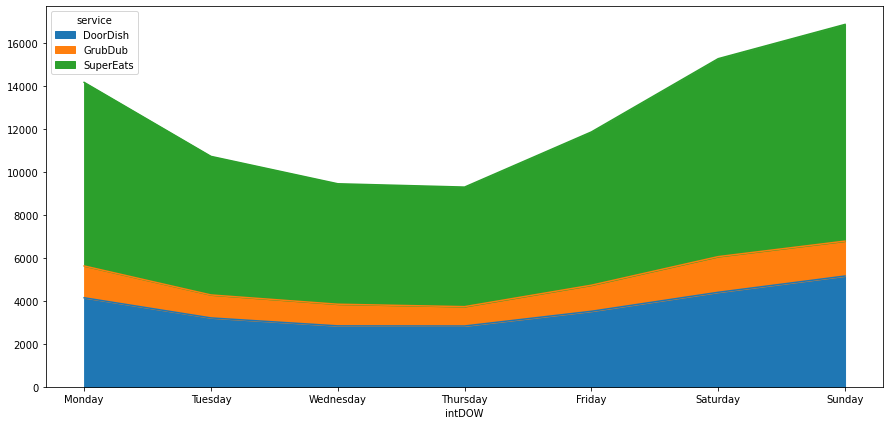

In [5]:
def visualize_order_volume(o_df: pd.DataFrame) -> None:
    # Charts number of items sold by day bucketed by delivery provider
    orders_by_day = (
        o_df.groupby(['intDOW', 'service'])
            .sum().sort_index()
    )

    # Get mapping of int DOW -> DOW for graph formatting
    dow = o_df['DOW'].unique() 
    int_dow = o_df['intDOW'].unique()
    mapping = dict(zip(int_dow, dow))

    (orders_by_day['item count']
         .unstack()
         .rename(mapping, axis='index')
         .plot(kind='area', stacked=True, figsize=(15,7)))

visualize_order_volume(build_order_df())

### Evaluation:
Looking at the bar chart, the lion's share of orders go through SuperEats and DoorDish where GrubDub only accounts for a small portion of the overall business. What's more, the data indicates a trend where order volume peaks on Mondays, Saturdays, and Sundays then drops off in the middle of the week. 

Let's check to see if there are any other trends we can surface with regards to ordering times and dates.

## Hour Binned Order Volume by Day

First order of set: 2020-01-20 16:01:00
Last order of set: 2020-01-27 09:59:00


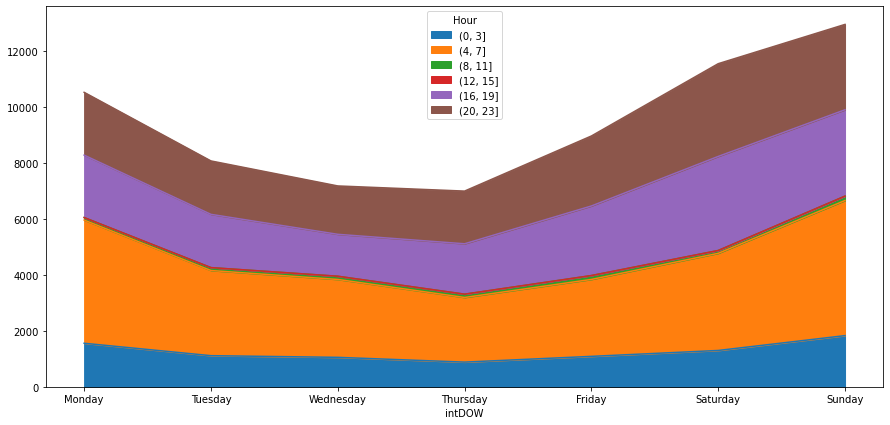

In [24]:
def visualize_hourly_volume(o_df: pd.DataFrame) -> None:

    # Shows volume of orders across six ~4 hour buckets
    rev_bins = pd.IntervalIndex.from_tuples([(0, 3), (4, 7), (8, 11), (12, 15), (16, 19), (20, 23)])
    binned = pd.cut(o_df['Hour'], rev_bins)
    orders_by_date_and_hour = o_df.groupby(['intDOW', binned]).sum()

    # Get mapping of int DOW -> DOW for graph formatting
    dow = o_df['DOW'].unique() 
    int_dow = o_df['intDOW'].unique()
    mapping = dict(zip(int_dow, dow))
    
    (orders_by_date_and_hour
         .unstack()
         .rename(mapping, axis='index')
         .plot(kind='area', y='item count', stacked=True, figsize=(15,7)))

visualize_hourly_volume(build_order_df())

### Evaluation:
When bucketed into 6 discrete bins of 4 hours each, the data indicates that between 8am and 4pm there are a very small amount of orders. This begs the question, what would be the revenue impact if we simply stopped cooking and taking orders between those hours?

## Cook Time
Assuming all order items are processed in parallel, this chart plots the sum total cook time for each hourly bucket on each day of the week.

In [25]:
from typing import Callable, Tuple
from data_processing.util import get_cooktime_window

def get_cooktime_report(
    o_df: pd.DataFrame, 
    agg_type: str = 'SUM',
    start: Tuple[int, int]=(0,0), 
    stop: Tuple[int, int]=(7, 23)) -> None:
    
    # SUM calculates the sum of cook time over all parallel orders at each hour step
    # AVG calculates the avg cook time over all parallel orders at each hour step
    opts = {
        'SUM': o_df.groupby(['intDOW', 'Hour']).sum,
        'AVG': o_df.groupby(['intDOW', 'Hour']).mean,
    }
    
    window = get_cooktime_window(start, stop)
    
    # Apply aggregation at each hour step for each day within window
    # Default to using the sum function
    x = opts.get(agg_type,  o_df.groupby(['intDOW', 'Hour']).sum)()
    
    # Calculate available indices by taking the intersection between brute forced
    # time indices and the available indices in the order dataframe
    target_indices = list(set(x.index).intersection(set(window)))
    
    return x.loc[target_indices].sort_index(ascending=True)
    # Render the chart within the specified window


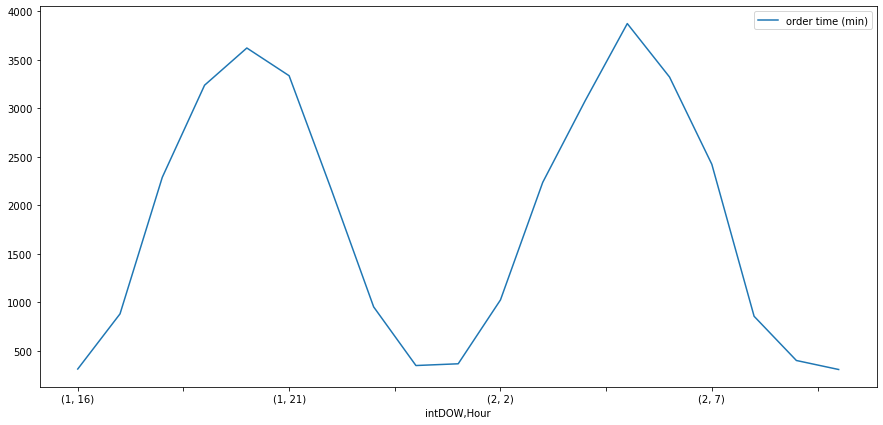

In [26]:
sum_report = get_cooktime_report(o_df, agg_type='SUM', start=(1, 15), stop=(2, 16))
sum_report.plot(kind='line', stacked=False, y=['order time (min)'], figsize=(15, 7))


### Evaluation
Nothing looks out of the ordinary with the cook times naturally ebbing and flowing over the course of a business day. While not incredibly important by itself, a sudden drop off could indicate issues with the order processing system.

## Average Order Fulfilment Time
This function plots the avg time to fulfil each order (processed in parallel) between a window of time.

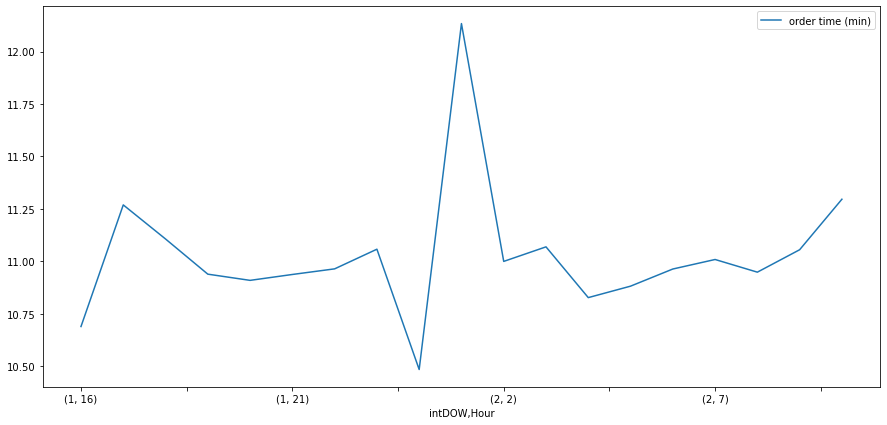

In [27]:
avg_report = get_cooktime_report(o_df, agg_type='AVG', start=(1, 15), stop=(2, 16))
avg_report.plot(kind='line', stacked=False, y=['order time (min)'], figsize=(15, 7))


What if we overlaid these charts with avg ticket price and number of items per ticket?

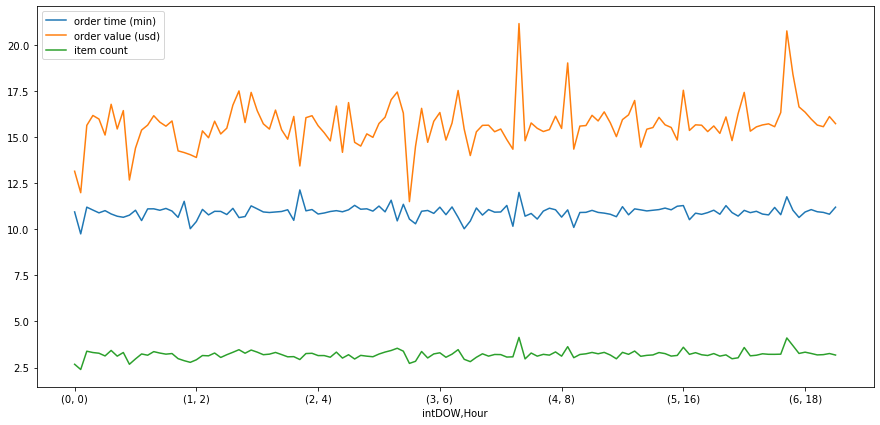

In [28]:
all_avg_report = get_cooktime_report(o_df, agg_type='AVG')
all_avg_report.plot(kind='line', stacked=False, y=['order time (min)', 'order value (usd)', 'item count'], figsize=(15, 7))

### Evaluation
The high level overview shows that there are a few cases where the average order fulfilment time spikes, but the average revenue per ticket drops. These are some places that could do with a bit more investigation. Potentially by eliminating the cheap menu items with long fulfilment times, we could improve efficiency as well as save on labor and ingredient costs.

## Drop Hours
Let's check to see if there are any time windows with low revenue; perhaps they could be dropped to save on labor and ingredient costs.

In [29]:
from typing import Tuple, List, Union

def calc_low_traffic_windows(o_df: pd.DataFrame) -> List[Union[float, Tuple[int, int]]]:
    def calculate_window_diff(start: int, stop: int) -> Tuple[float]:
        drop_low_vol = sum(o_df[(o_df['Hour'] < start) | (o_df['Hour'] >=stop)]['order value (usd)'])
        keep_low_vol = sum(o_df['order value (usd)'])
        diff = round((keep_low_vol - drop_low_vol), 2)
        return diff

    # Brute force all hourly windows to see what has the least revenue
    permutes = list() 
    for i in range(0, 24):
        for j in range(i+1, 24):
            permutes.append((i, j))

    return list(zip(map(lambda x: calculate_window_diff(x[0], x[1]), permutes), permutes)) 


In [30]:
all_window_diffs = calc_low_traffic_windows(build_order_df())

windowed = pd.DataFrame(all_window_diffs).rename(columns={0: 'Revenue', 1: 'Window'})
windowed['start'] = windowed['Window'].apply(lambda x: x[0])
windowed['stop'] = windowed['Window'].apply(lambda x: x[1])
windowed['diff'] = windowed['Window'].apply(lambda x: x[1] - x[0])
window_groups = windowed.groupby('Revenue').agg({'start': min, 'stop': max, 'diff': max}).reset_index(drop=False)
window_groups.iloc[:10]

First order of set: 2020-01-20 16:01:00
Last order of set: 2020-01-27 09:59:00


,Revenue,start,stop,diff
0,0.00,10,16,6
1,3325.44,1,2,1
2,3505.91,10,17,7
3,3570.39,0,1,1
4,4145.99,9,16,7
5,6895.83,0,2,2
6,7651.90,9,17,8
7,11707.01,17,18,1
8,11896.32,8,9,1
9,12415.67,2,3,1


### Evaluation:
We could drop service between 10am and 4pm without losing any revenue! Either that, or those are not currently working hours. If we were to expand that by 1 hour to 5pm, the cost would be 3500 dollars. Similarly, if costs were higher than 3300 dollars to keep staff during the 1-2am shift, then it would also make sense to stop service during that time as well.

Now that the operational side has been explored, let's take a look at how well the menu is performing.

## Menu Performance
The following dataframe aggregates quantity, revenue, and expected revenue for each menu item. 

In [31]:
from data_processing.dataframes import build_menu_perf_df, build_menu_df, build_order_df

# Builds the performance dataframe by joining the menu DF with the order data
# from orders.json 'items' column. Expected rev is derived from the price_per_item
# on the menu DF, where net_revenue is derived from the orders themselves
perf_df = build_menu_perf_df(build_order_df(), build_menu_df())

# Sort so we can see top performers by revenue
perf_df.sort_values(by='net_revenue', ascending=False).head()

First order of set: 2020-01-20 16:01:00
Last order of set: 2020-01-27 09:59:00


,name,net_revenue,quantity,expected_rev,diff,avg_diff,expected_rev (usd),net_revenue (usd),avg_diff (usd),dollar yield per min
77,Slow-Cooker Pot Roast,757390,939,750261,7129,7.592119,7502.61,7573.90,0.075921,1.01
29,Creamy Paprika Pork,736786,910,727090,9696,10.654945,7270.90,7367.86,0.106549,0.58
72,Skillet Ham & Rice,728240,924,719796,8444,9.138528,7197.96,7282.40,0.091385,1.58
34,Deviled Chicken,712801,882,704718,8083,9.164399,7047.18,7128.01,0.091644,1.01
20,Chicken Potpie Casserole,710936,935,701250,9686,10.359358,7012.50,7109.36,0.103594,1.09


,net_revenue (usd),percentage
net_revenue (usd),,
bottom quartile,84954.33,19.84
lower-quartile,124270.84,29.04
upper-quartile,114758.25,26.81
top-quartile,103990.16,24.28


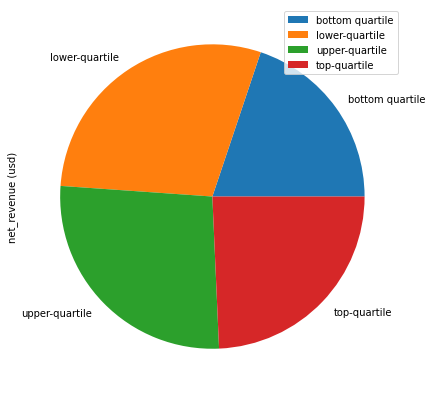

In [32]:
from typing import List

# Generate bins by quartile and Aggregates revenue for each menu item
# by quartile to see where most of the revenue is coming from 
labels=["bottom quartile", "lower-quartile", "upper-quartile", "top-quartile"]

def get_composition(df: pd.DataFrame, labels: List[str]=None, bins=4, target_col=''):
    temp_df = df.copy()
    temp_df['percentage'] = round((temp_df[target_col] / temp_df[target_col].sum()) * 100, 2)
    
    binned_rev = pd.cut(temp_df[target_col], bins=bins, labels=labels)
    bucketed_rev = (temp_df.groupby(binned_rev).sum()) 
    
    bucketed_rev.plot(kind='pie', y=target_col, figsize=(13, 7))
    
    return bucketed_rev[[target_col, 'percentage']]
    

get_composition(perf_df, labels=labels, bins=4, target_col='net_revenue (usd)')


## Evaluation
This chart indicates that lion's share of the revenue is coming from menu items that yield revenue within the two middle quartiles. Perhaps there is an opportunity to drop some menu items? Let's take another look at higher resolution.

,net_revenue (usd),percentage
net_revenue (usd),,
bin-1,36685.43,8.56
bin-2,48268.90,11.28
bin-3,42866.34,10.01
bin-4,81404.50,19.03
bin-5,80355.37,18.78
bin-6,34402.88,8.03
bin-7,46587.89,10.87
bin-8,57402.27,13.41


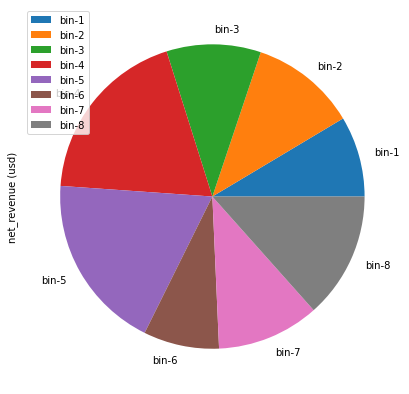

In [33]:
labels = [f'bin-{i}' for i in range(1,9)]

get_composition(perf_df, labels=labels, bins=8, target_col='net_revenue (usd)')

This supports the claim that we could cut items within specific revenue bands and have a minor effect on the overall business revenue. However, without additional information regarding the ingredient costs and operational overhead for items within these bins, it would be difficult to say with certainty that cutting items from these bands would benefit the overall business.

## Revenue By Cook Time
One possibe way to improve efficiency would be to evaluate the average revenue per item against its cook time. Using this derived metric, we could simulate the effects of removing menu items with low sale price and long cook times. 


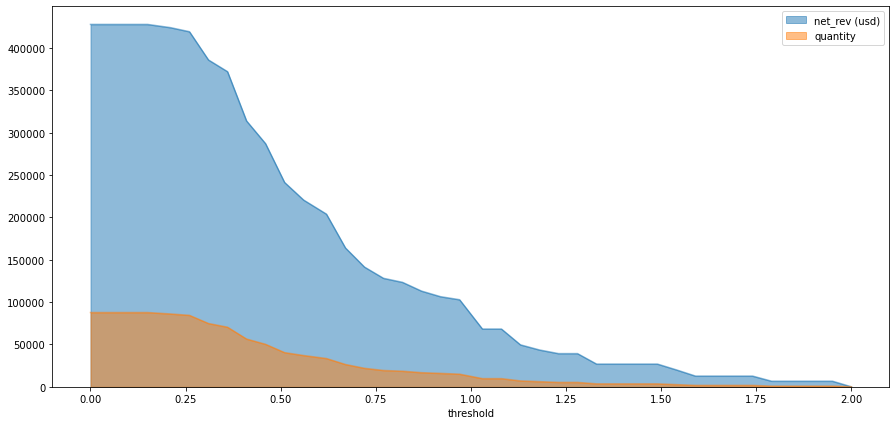

In [34]:
# Gets a list of tuples where the first element is the sum of revenue, the 2nd element is the total number of orders
# above a particular threshold, and the 3rd element is the dollar yield per min threshold. 
# This is to illustrate the effect of chopping items that
# fall below a specific dollar yield per minute threshold. eg: dropping items with < 0.25 dollar
# per min yield would only drop revenue by ~10k which could, (in theory), be offset by lower 
# cost of labor, inventory, delivery, etc etc.

calc = list(
    map(lambda x: (
        sum(perf_df[perf_df['dollar yield per min']>= x]['net_revenue (usd)']),
        sum(perf_df[perf_df['dollar yield per min']>= x]['quantity']),
        round(x, 2)
    ), np.linspace(0,2,40))
)


rev_at_yield_step = pd.DataFrame(calc, columns=['net_rev (usd)', 'quantity', 'threshold'])
rev_at_yield_step.plot(kind='area', x='threshold', figsize=(15,7), stacked=False)

This chart seems to support my earlier hypothesis - we could remove items from the menu with a low price to cook time ratio with a minor effect on overall business revenue. Let's dig in and see what the impact would be at different thresholds.

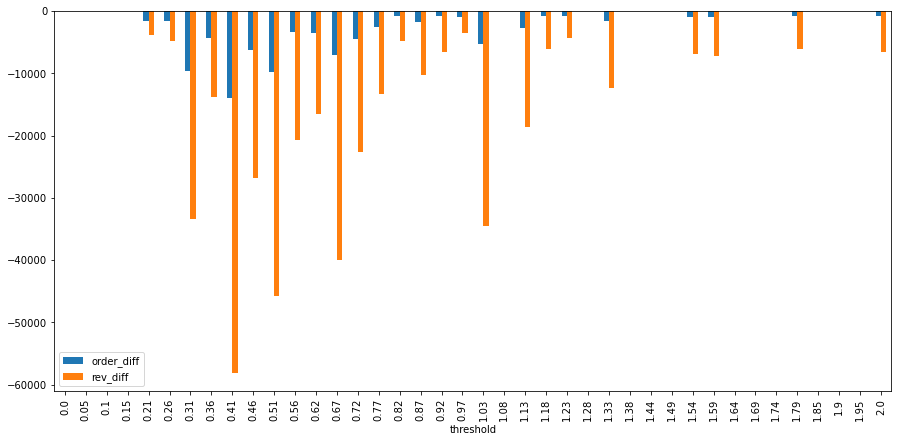

In [35]:
rev_at_yield_step
# # Uses the above data to calculate how much revenue would be lost at each threshold step
rev_at_yield_step['order_diff'] = rev_at_yield_step['quantity'].diff(periods=1)
rev_at_yield_step['rev_diff'] = rev_at_yield_step['net_rev (usd)'].diff(periods=1)

diff_df = rev_at_yield_step.loc[:, ['order_diff', 'rev_diff', 'threshold']]
diff_df.plot(kind='bar', x='threshold', figsize=(15,7), stacked=False)

### Evaluation
Yes, it looks like we could cut items from the menu without too much of an adverse revenue impact. To see what the concrete figures would look like, let's break into the data:

In [36]:
for k, v in diff_df.iterrows():
    above_threshold = perf_df[perf_df['dollar yield per min'] > v['threshold']]
    below_threshold = perf_df[perf_df['dollar yield per min'] <= v['threshold']]
    
    dropped_items = len(below_threshold)
    total_revenue = round(sum(above_threshold['net_revenue (usd)']))
    total_orders = round(sum(above_threshold['quantity']))
    total_items = len(above_threshold['quantity'])
    
    if dropped_items == 0 or total_revenue == 0:
        continue
    lost_revenue = round((v['rev_diff'] / total_revenue)*100, 2)
    lost_orders = round((v['order_diff'] / total_orders) *100, 2)
    print('At threshold {}:\ntotal menu: {} ----- {} dropped items\n${} total revenue ----- {} total orders\n\
rev change: {}% ------ volume change: {}%\n'.format(
        v['threshold'], total_items, dropped_items, total_revenue, total_orders, lost_revenue, lost_orders)
    )

At threshold 0.21:
total menu: 98 ----- 2 dropped items
$424186 total revenue ----- 86060 total orders
rev change: -0.89% ------ volume change: -1.96%

At threshold 0.26:
total menu: 96 ----- 4 dropped items
$419375 total revenue ----- 84415 total orders
rev change: -1.15% ------ volume change: -1.95%

At threshold 0.31:
total menu: 84 ----- 16 dropped items
$383773 total revenue ----- 73905 total orders
rev change: -8.69% ------ volume change: -13.02%

At threshold 0.36:
total menu: 77 ----- 23 dropped items
$363540 total revenue ----- 67810 total orders
rev change: -3.79% ------ volume change: -6.44%

At threshold 0.41:
total menu: 64 ----- 36 dropped items
$314045 total revenue ----- 56451 total orders
rev change: -18.52% ------ volume change: -24.76%

At threshold 0.46:
total menu: 57 ----- 43 dropped items
$287192 total revenue ----- 50211 total orders
rev change: -9.35% ------ volume change: -12.43%

At threshold 0.51:
total menu: 46 ----- 54 dropped items
$241392 total revenue -

### Evaluation
While the initial charts seemed to indicate that we could cut items by their price - cook time ratio, the raw numbers seem to suggest there is a minimal opportunity here. For example, at the threshold of .21 we would drop 2 menu items, lose .89% aggregate revenue, and fulfill 1.96% fewer orders. By the 2nd step, we would cut 6 items total, fulfil 3.9% fewer orders, and lose ~2% of our overall revenue. 

Without understanding more about the costs related to each of these 6 items, it's difficult to say whether or not the cuts would have a net-positive impact on the business.

## Ordered Together
Let's see if there are any item combos that people order frequenly. Perhaps there is an opportunity to suggest common pairings to other users who order 1 of the N items? Or maybe there's an opportunity to offer discounts and specials on common pairings? After all, if ticket items are fulfilled in parallel and delivered through a single supplier, this would definitely improve efficiency and aggregate revenue.

In [37]:
from data_processing.util import gen_n_grams, get_ngram_frequency
from data_processing.dataframes import gen_mappings, build_ngram_df

time_map, price_map = gen_mappings()
bigrams = gen_n_grams(2, build_order_df())
bigram_df = build_ngram_df(bigrams, price_map, time_map)
bigram_df.head()

First order of set: 2020-01-20 16:01:00
Last order of set: 2020-01-27 09:59:00


,combo,frequency,price,time,time saved,time saved (min),time (min),price (usd)
0,"(Easy Chicken Cordon Bleu, De-Lightful Tuna Ca...",30,1680,900,349,5.816667,15.0,16.8
1,"(Tender Salsa Beef, Sausage Spaghetti Spirals)",28,1020,600,250,4.166667,10.0,10.2
2,"(Sunday Roast Chicken, Homemade Fish Sticks)",27,780,540,279,4.650000,9.0,7.8
3,"(Slow Cooker Mushroom Beef Stroganoff, Melt-in...",27,1140,660,249,4.150000,11.0,11.4
4,"(Garlic Herbed Beef Tenderloin, Favorite Chick...",27,1320,780,450,7.500000,13.0,13.2


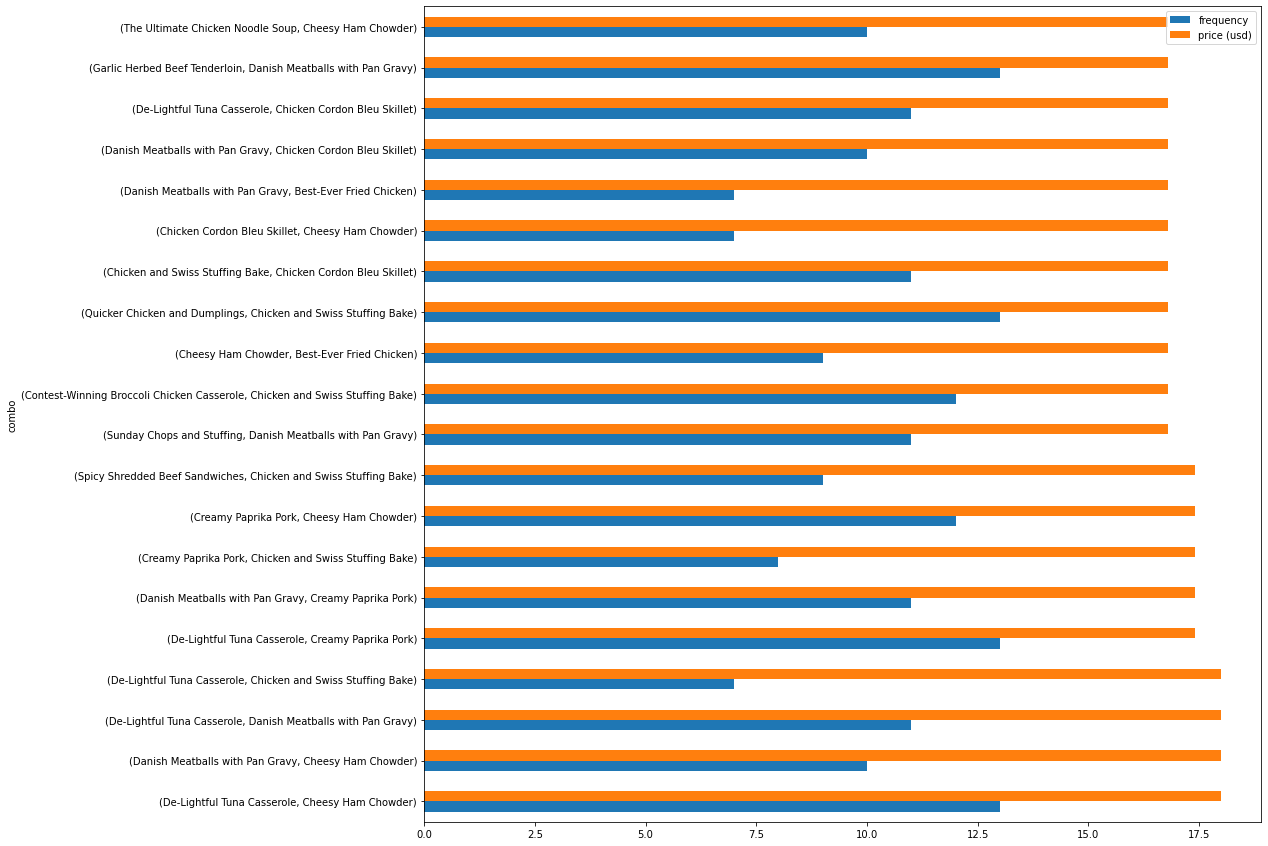

In [38]:
def inspect_ngram_window(ngram_df: pd.DataFrame, top: int=20) -> None:
    temp = ngram_df.copy().sort_values(by='price (usd)', ascending=False)
    avg = temp['frequency'].mean()
    window = temp[temp['frequency'] <= avg].iloc[:20]
    window.plot(kind='barh', x='combo', y=['frequency', 'price (usd)'], figsize=(15,15))
    
inspect_ngram_window(bigram_df, top=20)

### Evaluation
All right, this looks fairly promising. Looking at the top 20 most expensive combos with lower than average purchase frequency, there are a few cases where we could offer discounts or other incentives to upsell users on these combos.

In [39]:
time_map, price_map = gen_mappings()
trigrams = gen_n_grams(3, build_order_df())
trigram_df = build_ngram_df(trigrams, price_map, time_map)
trigram_df.head()

# Need to handle the n gram columns in the table

First order of set: 2020-01-20 16:01:00
Last order of set: 2020-01-27 09:59:00


,combo,frequency,price,time,time saved,time saved (min),time (min),price (usd)
0,"(Pork Chops with Creamy Mustard Noodles, Count...",5,960,360,749,12.483333,6.0,9.6
15,"(Traditional Meat Loaf, Spaghetti Pie Casserol...",4,1500,660,649,10.816667,11.0,15.0
1,"(Sugar-Glazed Ham, Puff Pastry Chicken Potpie,...",4,1800,780,750,12.500000,13.0,18.0
27,"(Sage Pork Chops with Cider Pan Gravy, Easy Me...",4,1680,900,729,12.150000,15.0,16.8
26,"(Spaghetti Pie Casserole, Skillet Ham & Rice, ...",4,840,300,1328,22.133333,5.0,8.4


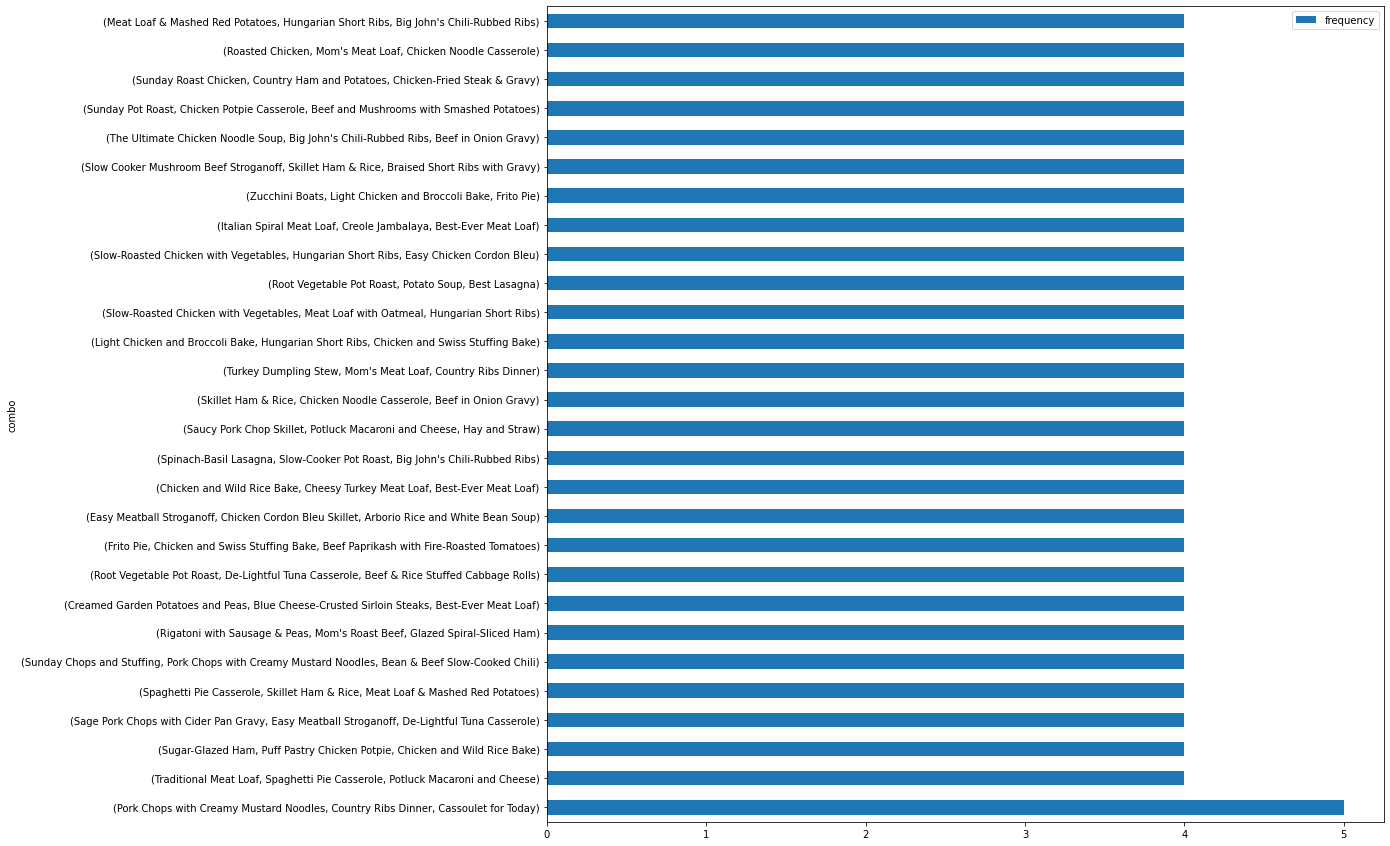

In [40]:
trigram_df[trigram_df['frequency'] >3 ].plot(kind='barh',x='combo', y='frequency', figsize=(15,15))

## Evaluation
Similar to above, these trigrams could be bundled into meal packages with discounts or other incentives.

# Conclusion
There are three main areas that are worth additional investigation:
1. How much is saved on operational expenses when dropping menu items
2. What is happening when the order avg value ticker drops when the avg fulfilment time spikes
3. Tracking the effect of incentivizing bundle purchases or frequently bought items

With more information regarding the costs / margins for individual menu items, we could more accurately model revenue when cutting items from the menu. Without that insight, I chose to highlight that certain bands of revenue account for a smaller portion of net revenue than I would have expected. 

For the order ticker, this seems like it would be a good candidate to host on a web service with granular updates. This could provide a high-level overview of the operational efficiency at any given moment.

We could also track the performance of incentives on upsells with some A/B testing experiments to see what levers have an effect on order size and value. 